In [1]:
import argparse
import glob
import os
import pathlib
import _pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

import phlearn.phsystems as phsys
import phlearn.phnns as phnn

from scipy.integrate import solve_ivp
from scipy.sparse import diags

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
ttype = torch.float32
torch.set_default_dtype(ttype)
%matplotlib notebook
custom_colors = sns.color_palette([(1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0.6,0.8,.8), (0,0.4,1), (0.5,0.3,.5)])
sns.set_palette(custom_colors)

plot_settings = {
    'axes.prop_cycle': mpl.cycler(color=custom_colors),
    'text.usetex': True,
    'font.family': 'serif',
    'axes.titlesize': 9,
    'figure.titlesize': 9,
    'legend.title_fontsize': 8,
    'axes.labelsize': 9,
    'font.size': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'savefig.dpi': 300,
}


plt.rcParams.update(plot_settings)

In [2]:
modelfolder = 'trained_models_bbm/'
df = pd.DataFrame(columns=['system_type', 'baseline', 'ntrainingpoints', 'sampling_time', 't_max',
                           'F_timedependent', 'F_spacedependent', 'F_statedependent', 'pHnn_model', 'val_loss'])
for f in glob.glob(modelfolder+"/*"):
    if ('DS_store' not in f) and ('.csv' not in f):
        model, optimizer, metadict = phnn.load_dynamic_system_model(f)
        #print('metadict[traininginfo]:', metadict['traininginfo'].keys())
        df.loc[f[19:]] = {'system_type': metadict['traininginfo']['system'],
                                   'baseline': int(metadict['traininginfo']['baseline']),
                                   'ntrainingpoints': metadict['traininginfo']['ntrainingpoints'],
                                   'sampling_time': metadict['traininginfo']['sampling_time'],
                                   't_max': metadict['traininginfo']['t_max'],
                                   'F_timedependent': bool(metadict['traininginfo']['F_timedependent']),
                                   'F_spacedependent': bool(metadict['traininginfo']['F_spacedependent']),
                                   'F_statedependent': bool(metadict['traininginfo']['F_statedependent']),
                                   'val_loss': metadict['traininginfo']['val_loss'],
                                   'pHnn_model': model}

In [3]:
df

,system_type,baseline,ntrainingpoints,sampling_time,t_max,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss
20230425153842641769.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.009052
20230425153407690530.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.016802
20230425153956174379.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000152
20230425152904671579.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000063
20230425152617863392.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000062
20230425152858888745.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.003122
20230425154320188944.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000092
20230425152522974155.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000078


In [4]:
dt_rollout = 0.01
extrapolate = False
t_max = 10
dt = 0.4
result_file = f'testresults_dt{dt_rollout:.0e}_n10_t{int(t_max)}.csv'
t_max = 12
stored_results_path = os.path.join(modelfolder, result_file)
stored_df = pd.read_csv(stored_results_path, index_col=0)

df.loc[stored_df.index, stored_df.columns] = stored_df.loc[stored_df.index, :].values.copy()


In [5]:
#df = df[14:]

In [6]:
df#[-5:]

,system_type,baseline,ntrainingpoints,sampling_time,t_max,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss,MSE,MSE endtime
20230425153842641769.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.009052,0.016782,0.077405
20230425153407690530.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.016802,3.041588,9.934124
20230425153956174379.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000152,0.141208,0.354450
20230425152904671579.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000063,0.007659,0.021752
20230425152617863392.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000062,0.037575,0.106619
20230425152858888745.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.003122,4.710052,18.112561
20230425154320188944.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000092,0.000327,0.000959
20230425152522974155.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000078,0.148998,0.836409


In [7]:
df = df[df['sampling_time'] == dt]
df['MSE'] = df['MSE']
df['Model type'] = df['baseline'].astype(int)
df['Model type'] = df['Model type'].map({1:'Baseline',# 2:'Baseline (2NN)',
                                         3:'PHNN (general)', 0:'PHNN (informed)', 4:'PHNN (no diss. term)'})
#df['Model type'] = df['Model type'].map({3:'PHNN (general)'})
type_order = ['PHNN (general)', 'PHNN (no diss. term)', 'PHNN (informed)', 'Baseline']

In [8]:
df

,system_type,baseline,ntrainingpoints,sampling_time,t_max,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss,MSE,MSE endtime,Model type
20230425153842641769.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.009052,0.016782,0.077405,PHNN (informed)
20230425153407690530.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.016802,3.041588,9.934124,Baseline
20230425153956174379.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000152,0.141208,0.354450,PHNN (no diss. term)
20230425152904671579.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000063,0.007659,0.021752,PHNN (no diss. term)
20230425152617863392.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000062,0.037575,0.106619,PHNN (general)
20230425152858888745.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.003122,4.710052,18.112561,Baseline
20230425154320188944.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000092,0.000327,0.000959,PHNN (informed)
20230425152522974155.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000078,0.148998,0.836409,PHNN (general)


In [9]:
#df = df[-5:]

In [10]:
x_max = 50
x_points = 100
dx = x_max/x_points
x = np.linspace(0,x_max-dx,x_points)
nu = 0. # coefficient of viscosity term
def F(u, t):
    t = np.reshape(t,(-1,1))
    return (np.sin(1*t)*.05*u).reshape(u.shape)
PDE_system = phsys.BBMSystem(x=x, nu=nu, force=F,# force_jac=JF,
                       init_sampler=phsys.initial_condition_bbm(x))

In [11]:
#df = df[4:]

In [12]:
#df = df[3:4]

In [13]:
df

,system_type,baseline,ntrainingpoints,sampling_time,t_max,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss,MSE,MSE endtime,Model type
20230425153842641769.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.009052,0.016782,0.077405,PHNN (informed)
20230425153407690530.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.016802,3.041588,9.934124,Baseline
20230425153956174379.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000152,0.141208,0.354450,PHNN (no diss. term)
20230425152904671579.model,bbm,4,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000063,0.007659,0.021752,PHNN (no diss. term)
20230425152617863392.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000062,0.037575,0.106619,PHNN (general)
20230425152858888745.model,bbm,1,250,0.4,10.0,True,False,True,DynamicSystemNN(\n (rhs_model): PDEBaselineNN...,0.003122,4.710052,18.112561,Baseline
20230425154320188944.model,bbm,0,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000092,0.000327,0.000959,PHNN (informed)
20230425152522974155.model,bbm,3,250,0.4,10.0,True,False,True,ConservativeDissipativeNN(\n (external_forces...,0.000078,0.148998,0.836409,PHNN (general)


In [14]:
#custom_order = ['PHNN (general)', 'PHNN (informed)', 'Baseline (1NN)', 'Baseline (2NN)']
custom_order = ['PHNN (general)', 'PHNN (no diss. term)', 'PHNN (informed)', 'Baseline']
df['Model type'] = pd.Categorical(df['Model type'], categories=custom_order)
# calculate mean and standard deviation of MSE endtime, grouped by Model type
result = df.groupby('Model type')['MSE endtime'].agg(['mean', 'std']).reset_index()
result = result.sort_values('Model type')
result['mean'] = result['mean'].apply(lambda x: '{:.2e}'.format(x))
result['std'] = result['std'].apply(lambda x: '{:.2e}'.format(x) if pd.notna(x) else '--')
print(result)

             Model type      mean       std
0        PHNN (general)  4.72e-01  5.16e-01
1  PHNN (no diss. term)  1.88e-01  2.35e-01
2       PHNN (informed)  3.92e-02  5.41e-02
3              Baseline  1.40e+01  5.78e+00


In [15]:
latex_table = result.to_latex(index=False, column_format='lS[table-format=1.2e]S[table-format=1.2e]')
print(latex_table)

\begin{tabular}{lS[table-format=1.2e]S[table-format=1.2e]}
\toprule
          Model type &     mean &      std \\
\midrule
      PHNN (general) & 4.72e-01 & 5.16e-01 \\
PHNN (no diss. term) & 1.88e-01 & 2.35e-01 \\
     PHNN (informed) & 3.92e-02 & 5.41e-02 \\
            Baseline & 1.40e+01 & 5.78e+00 \\
\bottomrule
\end{tabular}



/var/folders/qt/5hnkklzx3qz34g37fvg7b2h80000gn/T/ipykernel_36522/3320516013.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = result.to_latex(index=False, column_format='lS[table-format=1.2e]S[table-format=1.2e]')


<IPython.core.display.Javascript object>


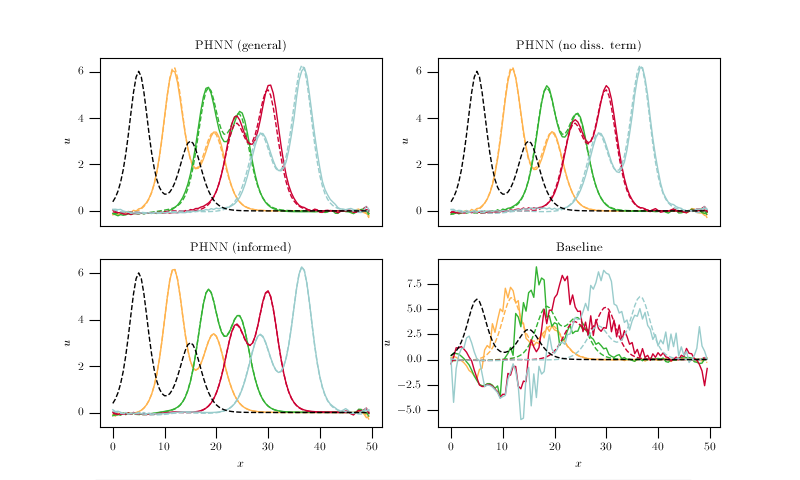

In [16]:
t_max = 9
P = (x[-1]-x[0])*x.size/(x.size-1)
c1, c2 = 3., 2.
d1, d2 = .1, .3
u0 = 3*(c1-1) * 1/np.cosh(1/2*np.sqrt(1 - 1/c1)*(x-P*d1))**2
u0 += 3*(c2-1) * 1/np.cosh(1/2*np.sqrt(1 - 1/c2)*(x-P*d2))**2

bestmodels = []
for modeltype, grp in df.groupby('Model type'):
    bestmodelstats = grp.sort_values('MSE').iloc[0]
    bestmodel, _, bestmodel_metadict = phnn.load_dynamic_system_model(modelfolder+'/'+bestmodelstats.name)
    bestmodels += [(bestmodel, bestmodelstats, bestmodel_metadict, modeltype)]
    
model_solutions_original = []
    
seeds = [20]
for seed in seeds:
    PDE_system.seed(seed)
    x = PDE_system.x
    u_exact_orig, dudt, t_sample, _ = PDE_system.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)
    N = t_sample.shape[0]-1
    #u0 = u_exact_orig[0, :]
    fig = plt.figure(figsize=(8, 4.8))
    col = 1
    for pHnn_model, modelstats, modeldict, modeltype in bestmodels:
        ax1 = fig.add_subplot(2, 2, col)
        ax1.set_title(modeltype)

        u_phnn, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        model_solutions_original.append((u_phnn, modeltype, 'Original'))
        for i in range(1,5):
            ax1.plot(x, u_exact_orig[int(i*N/4),:], color=custom_colors[i-1], linestyle='--', linewidth=1, label=f't = {i/4*t_max:.0f}, true')
            ax1.plot(x, u_phnn[int(i*N/4),:], color=custom_colors[i-1], linewidth=1, label=f't = {i/4*t_max:.0f}, model') 
        ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1, label='Initial condition') 
        if col > 2:
            ax1.set_xlabel('$x$')
        else:
            ax1.set_xticks([])
        ax1.set_ylabel('$u$')
        col += 1
    ax1.legend(bbox_to_anchor=(-0.19, -0.23), loc='upper center', ncol=5, fancybox=True)
    #fig.tight_layout()
    fig.savefig('figs/paper/bbm_waves.pdf', bbox_inches='tight')

In [17]:
ax1.legend(bbox_to_anchor=(-0.16, -0.28), loc='upper center', ncol=5, fancybox=True)
#fig.tight_layout()
fig.savefig('figs/paper/bbm_waves.pdf', bbox_inches='tight')

In [18]:
# model_solutions_original = []
# for pHnn_model, modelstats, modeldict, modeltype in bestmodels:
#     u_model, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
#     model_solutions_original.append((u_model, modeltype, 'Original'))

In [19]:
N = t_sample.shape[0]-1
u0 = u_exact_orig[0, :]
fig = plt.figure(figsize=(8, 1.))
ax1 = fig.add_subplot(1, 5, 1)
col = 2
ax1.set_title('Initial value')
ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1)
ax1.set_ylim([-1, 7])
ax1.set_ylabel('$u$')
ax1.set_xlabel('$x$')
for i in range(1,5):
    ax1 = fig.add_subplot(1, 5, col)
    ax1.set_title(f'$t = {i/4*t_max:.0f}$')
    for j, (u, modeltype, _) in enumerate(model_solutions_original):
        if modeltype == 'Baseline':
            #if modeltype=='PHNN (general)' or modeltype=='PHNN (lean)' or modeltype=='PHNN (informed)':
            ax1.plot(x, u[int(i*N/4),:], color=custom_colors[j], linewidth=1, label=modeltype) 
    for j, (u, modeltype, _) in enumerate(model_solutions_original):
        if modeltype != 'Baseline':
            #if modeltype=='PHNN (general)' or modeltype=='PHNN (lean)' or modeltype=='PHNN (informed)':
            ax1.plot(x, u[int(i*N/4),:], color=custom_colors[j], linewidth=1, label=modeltype) 
    ax1.plot(x, u_exact_orig[int(i*N/4),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
    ax1.set_xlabel('$x$')
    ax1.set_yticks([])
    ax1.set_ylim([-1, 8])
    col += 1
ax1.legend(bbox_to_anchor=(-1.84, -0.55), loc='upper center', ncol=5, fancybox=True)
#fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/paper/bbm_time.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>

In [20]:
# u_max, u_min = u_exact_orig.max(), u_exact_orig.min()
# for (u, _, _) in model_solutions_original:
#     if u.max() > u_max:
#         u_max = u.max()
#     if u.min() < u_min:
#         u_min = u.min()
# u_min = max(u_min, -2)
# u_max = min(u_max, 10)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 1.6))
# ax1 = fig.add_subplot(1, 3, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,3):
#     ax1 = fig.add_subplot(1, 3, col)
#     ax1.set_title(f'$t = {i/2*t_max}$')
#     for j, (u, modeltype, _) in enumerate(model_solutions_original):
#         ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j], linewidth=1, label=modeltype) 
#     ax1.plot(x, u_exact_orig[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#     ax1.set_xlabel('$x$')
#     ax1.set_yticks([])
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     col += 1
# ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/bbm_waves_time.pdf', bbox_inches='tight')

#### Removing the external force

In [21]:
# PDE_system_no_force = phsys.BBMSystem(x=x, nu=nu, force=None, force_jac=None,
#                        init_sampler=phsys.initial_condition_bbm(x))
# u_exact_no_force, _, _, _ = PDE_system_no_force.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)

In [22]:
# model_solutions_no_force = []
# for model, modelstats, modeldict, modeltype in bestmodels:
#     if modeltype=='Baseline':
#         def basemodel_no_force(u, t, x):
#             return (model.rhs_model(u,t,x) - 
#                     model.rhs_model(torch.zeros_like(u),t,x))
#         u_dot = lambda t, u: basemodel_no_force(
#                                  torch.tensor(u.reshape(1, u.shape[-1]), dtype=ttype),
#                                  torch.tensor(np.array(t).reshape((1, 1)), dtype=ttype),
#                                  torch.tensor(x.reshape(1, x.shape[-1]), dtype=ttype)
#                                  ).detach().numpy().flatten()
#         out_ivp = solve_ivp(fun=u_dot, t_span=(t_sample[0], t_sample[-1]),
#                             y0=u0.flatten(), t_eval=t_sample, rtol=1e-10)
#         u_model = out_ivp['y'].T
#         model_solutions_no_force.append((u_model, modeltype, 'No force'))
#     else:
#         def dissintegral(x):
#             return torch.zeros((1,x.shape[1]))
#         def dissintegral_grad(x):
#             return torch.zeros_like(x)
#         phmodel = phnn.ConservativeDissipativeNN(
#                                                  PDE_system.nstates,
#                                                  kernel_sizes=model.kernel_sizes[:3]+[0],
#                                                  structure_matrix=model.S(),
#                                                  dissipation_matrix=model.P(),
#                                                  symmetric_matrix=model.D_flat(),
#                                                  hamiltonian_true=model.hamiltonian,
#                                                  grad_hamiltonian_true=model.dH,
#                                                  dissintegral_true=model.dissintegral,
#                                                  grad_dissintegral_true=model.dV
#                                                  #dissintegral_true=dissintegral,
#                                                  #grad_dissintegral_true=dissintegral_grad
#                                                 )
#         u_model, _ = phmodel.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
#         model_solutions_no_force.append((u_model, modeltype, 'No force'))

In [23]:
# u_max, u_min = u_exact_no_force.max(), u_exact_no_force.min()
# for (u, _, _) in model_solutions_no_force:
#     if u is not None:
#         if u.max() > u_max:
#             u_max = u.max()
#         if u.min() < u_min:
#             u_min = u.min()
# u_min = min(max(u_min, -2), -.15)
# u_max = min(u_max, 6)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 1.6))
# ax1 = fig.add_subplot(1, 3, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_no_force[0,:], color='k', linestyle='--', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,3):
#     ax1 = fig.add_subplot(1, 3, col)
#     ax1.set_title(f'$t = {i/2*t_max}$')
#     for j, (u, modeltype, _) in enumerate(model_solutions_no_force):
#         if u is not None:
#             ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j+1], linewidth=1, label=modeltype) 
#     ax1.plot(x, u_exact_no_force[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#     ax1.set_xlabel('$x$')
#     ax1.set_yticks([])
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     col += 1
# ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/bbm_waves_time.pdf', bbox_inches='tight')

#### Removing force and dissipation

In [24]:
PDE_system_no_visc = phsys.BBMSystem(x=x, nu=0., force=None, force_jac=None,
                       init_sampler=phsys.initial_condition_bbm(x))
u_exact_no_visc, _, _, _ = PDE_system_no_visc.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)

In [25]:
model_solutions_no_visc = []
for model, modelstats, modeldict, modeltype in bestmodels:
    if modeltype=='PHNN (general)' or modeltype=='PHNN (informed)' or modeltype=='PHNN (no diss. term)':
        phmodel = phnn.ConservativeDissipativeNN(
                                                 PDE_system.nstates,
                                                 kernel_sizes=model.kernel_sizes[:2]+[0,0],
                                                 structure_matrix=model.S(),
                                                 symmetric_matrix=model.D_flat(),
                                                 hamiltonian_true=model.hamiltonian,
                                                 grad_hamiltonian_true=model.dH,
                                                )
        u_model, _ = phmodel.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        model_solutions_no_visc.append((u_model, modeltype, 'No force (or diss. term)'))
    else:
        model_solutions_no_visc.append((None, None, None))

In [26]:
# u_max, u_min = u_exact_no_visc.max(), u_exact_no_visc.min()
# for (u, _, _) in model_solutions_no_visc:
#     if u is not None:
#         if u.max() > u_max:
#             u_max = u.max()
#         if u.min() < u_min:
#             u_min = u.min()
# u_min = min(max(u_min, -2), -.15)
# u_max = min(u_max, 6)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 1.6))
# ax1 = fig.add_subplot(1, 3, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_no_visc[0,:], color='k', linestyle='--', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,3):
#     ax1 = fig.add_subplot(1, 3, col)
#     ax1.set_title(f'$t = {i/2*t_max}$')
#     for j, (u, modeltype, _) in enumerate(model_solutions_no_visc):
#         if u is not None:
#             ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j+1], linewidth=1, label=modeltype) 
#     ax1.plot(x, u_exact_no_visc[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#     ax1.set_xlabel('$x$')
#     ax1.set_yticks([])
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     col += 1
# ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=3, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/bbm_waves_time.pdf', bbox_inches='tight')

In [27]:
all_models = [model_solutions_original, model_solutions_no_visc]
all_exact = [u_exact_orig, u_exact_no_visc]
model_names = ['Baseline', 'PHNN (general)', 'PHNN (no diss. term)', 'PHNN (informed)']

# col = 1

# fig = plt.figure(figsize=(8, 5))

# for m, model_solution in enumerate(all_models):
    
#     u_exact = all_exact[m]
#     model_solutions = all_models[m]
#     u_max, u_min = u_exact.max(), u_exact.min()
#     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
#     u_min = min(max(u_min, -2), -.15)
#     u_max = min(u_max, 6)
    
#     ax1 = fig.add_subplot(3, 3, 1+3*m)
    
#     if m == 0:
#         ax1.set_title('Initial value')
#     if m != 2:
#         ax1.set_xticks([])
#     ax1.plot(x, u_exact_no_visc[0,:], color='k', linestyle='--', linewidth=1)
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     ax1.set_ylabel('$u$')
#     if m == 2:
#         ax1.set_xlabel('$x$')
        
#     for i in range(1,3):
#         ax1 = fig.add_subplot(3, 3, 1+i+3*m)
#         if m == 0:
#             ax1.set_title(f'$t = {i/2*t_max}$')
#         if m != 2:
#             ax1.set_xticks([])
#         for j, (u, modeltype, _) in enumerate(model_solution):
#             if u is not None:
#                 ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j], linewidth=1, label=modeltype) 
#         ax1.plot(x, u_exact[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#         if m == 2:
#             ax1.set_xlabel('$x$')
#         ax1.set_yticks([])
#         ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     if m == 0:
#         ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

# #ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/bbm_all.pdf', bbox_inches='tight')

In [28]:
# col = 1

# fig = plt.figure(figsize=(8, 6))

# for m, model_solution in enumerate(all_models):
    
#     u_exact = all_exact[m]
#     model_solutions = all_models[m]
# #     u_max, u_min = u_exact.max(), u_exact.min()
# #     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
# #     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
# #     u_min = min(max(u_min, -2), -.15)
# #     u_max = min(u_max, 6)
#     u_min = -2.
#     u_max = 7.
    
#     ax1 = fig.add_subplot(5, 5, 1+5*m)
    
#     if m == 0:
#         ax1.set_title('Initial value')
#     if m != 2:
#         ax1.set_xticks([])
#     ax1.plot(x, u_exact_no_visc[0,:], color='k', linestyle='--', linewidth=1)
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     ax1.set_ylabel(model_solution[-1][-1]+'\n$u$')
#     if m == 2:
#         ax1.set_xlabel('$x$')
        
#     for j, (u, modeltype, _) in enumerate(model_solution):
#         if u is not None:
#             ax1 = fig.add_subplot(5, 5, 1+j+1+5*m)
#             if m == 0:
#                 ax1.set_title(modeltype)
#             if m != 2:
#                 ax1.set_xticks([])
#             ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
#             ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#             if m == 2:
#                 ax1.set_xlabel('$x$')
#             ax1.set_yticks([])
#             ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     #if m == 0:
#     #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

# #ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# fig.subplots_adjust(wspace=0.1)
# #fig.savefig('figs/paper/bbm_spread.pdf', bbox_inches='tight')

#### Extracting the force term

In [29]:
model_forces = []
for model, modelstats, modeldict, modeltype in bestmodels:
    if modeltype=='Baseline':
        model_forces.append((None, modeltype, 'Force'))
    else:
        u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        F_model = model.external_forces(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype),
                                        torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                                        torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                                       ).detach().numpy().reshape(u_model.shape)
        if model.kernel_sizes[0] > 1:
            d = int((model.kernel_sizes[0]-1)/2)
            M = x.size
            D_flat = model.D_flat().detach().numpy()
            diagonals = np.concatenate([D_flat[0,:,(d+1):], D_flat[0], D_flat[0,:,:-(d+1)]], axis=1).T.repeat(M, axis=1)
            offsets = np.concatenate([np.arange(-M+1,-M+1+d),np.arange(-d,d+1),np.arange(M-d,M)])
            D = diags(diagonals, offsets, (M,M)).toarray()
            F_model = np.matmul(PDE_system.lhs_matrix, np.linalg.solve(D, F_model.T)).T
        model_forces.append((F_model, modeltype, 'Force'))
F_exact = PDE_system.external_forces(u_exact_orig, t_sample)#.reshape(1,-1)

In [30]:
#u_exact = all_exact[0]
#F_exact = PDE_system.external_forces(u_exact, t_sample).reshape(1,-1)

In [31]:
# col = 1

# fig = plt.figure(figsize=(8, 6))

# for mp, model_solution in enumerate(all_models):
#     if mp > 0:
#         m = mp+1
#     else:
#         m = mp

#     u_exact = all_exact[mp]
#     model_solutions = all_models[mp]
# #     u_max, u_min = u_exact.max(), u_exact.min()
# #     u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
# #     u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
# #     u_min = min(max(u_min, -2), -.15)
# #     u_max = min(u_max, 6)
#     u_min = -2.
#     u_max = 6.
        
#     for jp, (u, modeltype, _) in enumerate(model_solution):
#         if jp < 2:
#             j = jp + 2
#         else:
#             j = jp - 2
#         if u is not None:
#             ax1 = fig.add_subplot(4, 4, j+1+4*m)
#             if m == 0:
#                 ax1.set_title(modeltype)
#             ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
#             ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#             if (m == 3) or (m == 2 and j > 1):
#                 ax1.set_xlabel('$x$')
#             else:
#                 ax1.set_xticks([])
#             if j == 0:
#                 ax1.set_ylabel(model_solution[0][-1]+'\n$u$')
#             else:
#                 ax1.set_yticks([])
#             ax1.set_ylim([-1, 10])
#     #if m == 0:
#     #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

# m = 1
# F_max, F_min = 1.3*F_exact[-1,:].max(), 1.3*F_exact[-1,:].min()
# F_max = max(F[-1,:].max() for (F, _, _) in model_forces if F is not None)
# F_min = min(F[-1,:].min() for (F, _, _) in model_forces if F is not None)
# #F_min = min(max(F_min, -2), -.15)
# #F_max = min(F_max, 6)
# #F_min = -.5
# #F_max = 2.2
# for jp, (F, modeltype, _) in enumerate(model_forces):
#     if jp < 2:
#         j = jp + 2
#     else:
#         j = jp - 2
#     if F is not None:
#         ax1 = fig.add_subplot(4, 4, j+1+4*m)
#         if m == 0:
#             ax1.set_title(modeltype)
#         ax1.plot(x, F[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
#         ax1.plot(x, F_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#         ax1.set_xticks([])
#         if j == 0:
#             ax1.set_ylabel('$f$')
#         else:
#             ax1.set_yticks([])
#         ax1.set_ylim([-.4, .1])


# #ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/bbm_spread.pdf', bbox_inches='tight')

In [34]:
col = 1
lw = 1

fig = plt.figure(figsize=(8, 3.7))

for mp, model_solution in enumerate(all_models):
    if mp > 0:
        m = mp+1
    else:
        m = mp

    u_exact = all_exact[mp]
    model_solutions = all_models[mp]
    u_max, u_min = u_exact.max(), u_exact.min()
    u_max = max(u.max() for (u, _, _) in model_solutions if u is not None)
    u_min = min(u.min() for (u, _, _) in model_solutions if u is not None)
#    u_min = min(max(u_min, -2), -.15)
#     u_max = min(u_max, 6)
#    u_min = -.5
#    u_max = 2.2
        
    for jp, (u, modeltype, _) in enumerate(model_solution):
#         if jp == 0:
#             j = 3
#         if jp == 1:
#             j = 0
#         if jp == 2:
#             j = jp
#         if jp == 3:
#             j = 1
        j = jp
        #plotdf = df[df['Model type']==modeltype].copy()
        grp = df[df['Model type']==modeltype]
        u_phnn = np.zeros((grp.shape[0], t_sample.shape[0], PDE_system.nstates))
        mse = 0
        for k, modelpath in enumerate(grp.index):
            model, _, metadict = phnn.load_dynamic_system_model(modelfolder+'/'+modelpath)
            if model_solutions[-1][-1]=='No force (or diss. term)':
                if modeltype=='Baseline':
                    def basemodel_no_force(u, t, x):
                        return (model.rhs_model(u,t,x) - 
                                model.rhs_model(torch.zeros_like(u),t,x))
                    u_dot = lambda t, u: basemodel_no_force(
                                             torch.tensor(u.reshape(1, u.shape[-1]), dtype=ttype),
                                             torch.tensor(np.array(t).reshape((1, 1)), dtype=ttype),
                                             torch.tensor(x.reshape(1, x.shape[-1]), dtype=ttype)
                                             ).detach().numpy().flatten()
                    out_ivp = solve_ivp(fun=u_dot, t_span=(t_sample[0], t_sample[-1]),
                                        y0=u0.flatten(), t_eval=t_sample, rtol=1e-10)
                    u_phnn[k] = out_ivp['y'].T
                else:
                    phmodel = phnn.ConservativeDissipativeNN(
                                                             PDE_system.nstates,
                                                             kernel_sizes=model.kernel_sizes[:2]+[0,0],
                                                             structure_matrix=model.S(),
                                                             dissipation_matrix=model.P(),
                                                             symmetric_matrix=model.D_flat(),
                                                             hamiltonian_true=model.hamiltonian,
                                                             grad_hamiltonian_true=model.dH,
                                                             dissintegral_true=model.dissintegral,
                                                             grad_dissintegral_true=model.dV
                                                            )
                    u_phnn[k], _ = phmodel.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
            else:
                u_phnn[k], _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
            #mse += np.mean((u_exact - u_phnn[k])**2)
        meansim = np.mean(u_phnn, axis=0)
        stdsim = np.std(u_phnn, axis=0, ddof=1)
        if u is not None:
            ax1 = fig.add_subplot(3, 4, j+1+4*m)
            if m == 0:
                ax1.set_title(modeltype)
            #ax1.plot(x, u[-1,:], color=custom_colors[j], linewidth=1, label=modeltype)
            l = ax1.plot(x, meansim[-1,:], label=modeltype, color=custom_colors[j], alpha=1., linewidth=lw)
            ax1.fill_between(x, meansim[-1,:]-stdsim[-1,:],
                             meansim[-1,:]+stdsim[-1,:], alpha=0.3, color=l[0].get_color())
            #ax1.plot(x, meansim[int(i*N/4),:], label=integrator, color=custom_colors[0], alpha=1., linewidth=lw)
            ax1.plot(x, u_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
            if m == 2:
                ax1.set_xlabel('$x$')
            else:
                ax1.set_xticks([])
            if j == 0:
                ax1.set_ylabel(model_solution[0][-1]+'\n$u$')
            else:
                ax1.set_yticks([])
            ax1.set_ylim([-1, 8.5])
    #if m == 0:
    #    ax1.legend(bbox_to_anchor=(-0.6, -2.77), loc='upper center', ncol=3, fancybox=True)

m = 1
F_max, F_min = F_exact.max(), F_exact.min()
F_max = max(F.max() for (F, _, _) in model_forces if F is not None)
F_min = min(F.min() for (F, _, _) in model_forces if F is not None)
#F_min = min(max(F_min, -2), -.15)
#F_max = min(F_max, 6)
#F_min = -.5
#F_max = 2.2
for jp, (F, modeltype, _) in enumerate(model_forces):
#     if jp == 0:
#         j = 3
#     if jp == 1:
#         j = 0
#     if jp == 2:
#         j = jp
#     if jp == 3:
#         j = 1
    j = jp
    grp = df[df['Model type']==modeltype]
    F_phnn = np.zeros((grp.shape[0], t_sample.shape[0], PDE_system.nstates))
    mse = 0
    if F is not None:
        for k, modelpath in enumerate(grp.index):
            model, _, metadict = phnn.load_dynamic_system_model(modelfolder+'/'+modelpath)
            if modeltype=='Baseline':
                u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
                F_phnn[k] = model.rhs_model(
                               torch.zeros_like(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype)),
                               torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                               torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                              ).detach().numpy().reshape(u_model.shape)
            else:
                u_model, _ = model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
                F_model = model.external_forces(torch.tensor(u_model.reshape(-1,1,u_model.shape[-1]), dtype=ttype),
                                                torch.tensor(t_sample.reshape(-1,1,1),dtype=ttype),
                                                torch.tensor(np.tile(x.reshape(-1, 1, 1), u_model.shape[0]).T, dtype=ttype)
                                               ).detach().numpy().reshape(u_model.shape)
                if model.kernel_sizes[0] > 1:
                    d = int((model.kernel_sizes[0]-1)/2)
                    M = x.size
                    D_flat = model.D_flat().detach().numpy()
                    diagonals = np.concatenate([D_flat[0,:,(d+1):], D_flat[0], D_flat[0,:,:-(d+1)]], axis=1).T.repeat(M, axis=1)
                    offsets = np.concatenate([np.arange(-M+1,-M+1+d),np.arange(-d,d+1),np.arange(M-d,M)])
                    D = diags(diagonals, offsets, (M,M)).toarray()
                    F_phnn[k] = np.matmul(PDE_system.lhs_matrix, np.linalg.solve(D, F_model.T)).T
                else:
                    F_phnn[k] = F_model
            #F_phnn[k] = F_model
            meansim = np.mean(F_phnn, axis=0)
            stdsim = np.std(F_phnn, axis=0, ddof=1)
            ax1 = fig.add_subplot(3, 4, j+1+4*m)
            if m == 0:
                ax1.set_title(modeltype)
            #ax1.plot(x, F_model[-1,:], color=custom_colors[j], linewidth=1, label=modeltype) 
            l = ax1.plot(x, meansim[-1,:], label=modeltype, color=custom_colors[j], alpha=1., linewidth=lw)
            ax1.fill_between(x, meansim[-1,:]-stdsim[-1,:],
                             meansim[-1,:]+stdsim[-1,:], alpha=0.2, color=l[0].get_color())
            ax1.plot(x, F_exact[-1,:], color='k', linestyle='--', linewidth=1, label='Ground truth')
            ax1.set_xticks([])
            if j == 0:
                ax1.set_ylabel('$f$')
            else:
                ax1.set_yticks([])
            ax1.set_ylim([-.1, .2])


#ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/paper/bbm_spread_std.pdf', bbox_inches='tight')